# Random Forest Classification - Customer Retention

The problem tackled in this notebook is the classic marketing application - customer retention (commonly referred to as churn). It is a basic binary classification problem which will use a combination of categorical and numerical features.

## Environment

Sklearn will create the models and scikitplot is an awesome library for plotting various important classification plots.

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from scikitplot.metrics import plot_roc, plot_confusion_matrix

from math import sqrt
import os

## Result Functions

In [2]:
def rf_results(model, X_test, y_pred_test, y_test, y_pred_train, y_train, verbose = True, plot = True):
    
    results = {
               'Test Accuracy': metrics.accuracy_score(y_test, y_pred_test),
               'OOB Score': model.oob_score_,
               'Train Accuracy': metrics.accuracy_score(y_train, y_pred_train),
              }
    
    if verbose:
        print('Random Forest Model Results:')
        print(results)
    
    if plot:
        y_true = y_test
        y_probas = model.predict_proba(X_test)
        plot_roc(y_true, y_probas, title='ROC Curves')
        plt.show()
        plot_confusion_matrix(y_pred_test, y_test, normalize=True)
        plt.show()
    
    return results

def plot_importance(model):
    importances = model.feature_importances_
    indices = np.argsort(importances)
    features = train_features.columns
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

## Data Loading

In [3]:
df = pd.read_csv('/Users/ClayElmore/Desktop/gitClay/My_Learning_General_ML_/datasets/datasets_729058_1265963_Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

# Preprocessing

In [5]:
drop_cols = ['RowNumber','CustomerId','Surname']
cont_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
cat_cols = ['HasCrCard','IsActiveMember', 'Geography', 'Gender']
y_var = 'Exited'
features = df[cont_cols + cat_cols]
labels = df[y_var]

In [6]:
features.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,HasCrCard,IsActiveMember,Geography,Gender
0,619,42,2,0.00,1,101348.88,1,1,France,Female
1,608,41,1,83807.86,1,112542.58,0,1,Spain,Female
2,502,42,8,159660.80,3,113931.57,1,0,France,Female
3,699,39,1,0.00,2,93826.63,0,0,France,Female
4,850,43,2,125510.82,1,79084.10,1,1,Spain,Female


In [7]:
# Split data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, 
                                                                            test_size = 0.25, random_state = 42)

In [8]:
# check for missing values
df.isna().any()

RowNumber          False
CustomerId         False
Surname            False
CreditScore        False
Geography          False
Gender             False
Age                False
Tenure             False
Balance            False
NumOfProducts      False
HasCrCard          False
IsActiveMember     False
EstimatedSalary    False
Exited             False
dtype: bool

In [9]:
# encode categorical variables
for col in cat_cols:
    le = preprocessing.LabelEncoder()
    le.fit(train_features[col])
    train_features[col] = le.transform(train_features[col])
    test_features[col] = le.transform(test_features[col])

In [10]:
# scale continuous variables
for col in cont_cols:
    le = preprocessing.StandardScaler()
    le.fit(train_features[col].astype(float).to_numpy().reshape(-1,1))
    train_features[col] = le.transform(train_features[col].astype(float).to_numpy().reshape(-1,1))
    test_features[col] = le.transform(test_features[col].astype(float).to_numpy().reshape(-1,1))

In [11]:
train_features.head(10)

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,HasCrCard,IsActiveMember,Geography,Gender
4901,0.218351,1.916619,-1.731689,1.629928,0.813111,-1.382844,0,1,0,1
4375,2.057280,0.202109,1.041750,-0.246244,-0.911043,-1.195890,1,0,1,1
6698,0.758602,-0.750397,0.348390,-1.221027,-0.911043,-0.683422,0,0,0,0
9805,-0.082942,-0.559895,0.695070,1.574101,-0.911043,-0.985396,0,1,0,1
1101,0.530034,-0.940898,1.388429,-1.221027,0.813111,-0.868375,1,0,2,1
9537,1.361189,0.106858,0.348390,-1.221027,0.813111,0.157636,1,0,0,1
7655,0.997558,-0.083643,-0.344970,0.623826,-0.911043,-0.516130,0,1,0,1
5235,-0.072553,2.773874,1.388429,-1.221027,4.261421,1.314771,1,1,0,0
5165,2.057280,-0.559895,0.695070,1.035889,-0.911043,-1.687775,0,0,0,1
118,-1.329674,-0.750397,1.041750,0.505298,-0.911043,1.720768,1,0,1,0


# Random Forest Modeling

## Base Case
The base case is EXTREMELY overfit, meaning we need to hypertune to generalize the model.

Random Forest Model Results:
{'Test Accuracy': 0.8664, 'OOB Score': 0.8556, 'Train Accuracy': 0.9998666666666667}


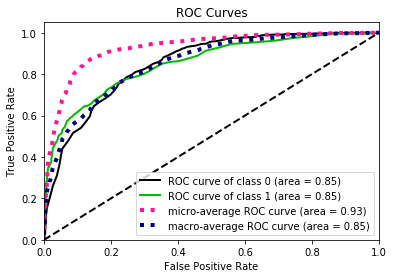

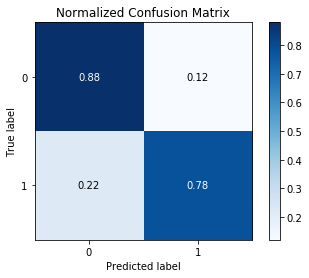

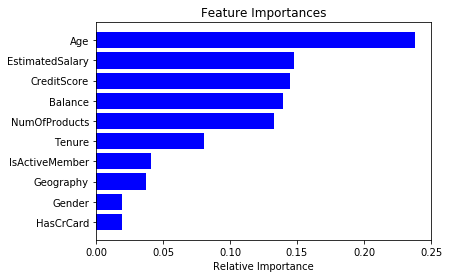

In [15]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 42, oob_score = True) 
rf.fit(train_features, train_labels)
pred_train_labels = rf.predict(train_features)
pred_test_labels = rf.predict(test_features)
results = rf_results(model = rf, 
                     X_test = test_features,
                     y_pred_test = pred_test_labels, 
                     y_test = test_labels, 
                     y_pred_train = pred_train_labels, 
                     y_train = train_labels,
                     verbose = True)
plot_importance(rf)

## Coarse Random Hyperparameter Search

In [16]:
params = {
    'n_estimators' : [50,100,150,200,300,500],
    'max_depth' : range(2,7),
    'min_samples_split' : range(5,100),
}
model = RandomForestClassifier(n_estimators = 100, random_state = 42, oob_score = True) 
n_iters = 100
clf = RandomizedSearchCV(model, params, random_state=42, verbose = 10, n_iter = n_iters, n_jobs = -1)
search = clf.fit(train_features, train_labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/ClayElmore/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   47.5s
[Parallel(n_jo

In [17]:
search.best_params_

{'n_estimators': 150, 'min_samples_split': 50, 'max_depth': 6}

## Fine Grid Search

In [18]:
params = {
    'n_estimators' : range(140,160),
    'max_depth' : range(5,7),
    'min_samples_split' : range(40,60),
}
model = RandomForestClassifier(n_estimators = 100, random_state = 42, oob_score = True) 
n_iters = 100
clf = GridSearchCV(model, params, verbose = 10, n_jobs = -1)
search = clf.fit(train_features, train_labels)

/Users/ClayElmore/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 800 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.0min
[Paralle

## Best RF Model  Results

Random Forest Model Results:
{'Test Accuracy': 0.86, 'OOB Score': 0.8545333333333334, 'Train Accuracy': 0.8594666666666667}


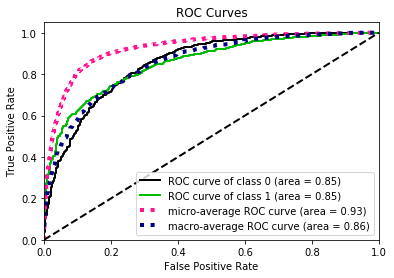

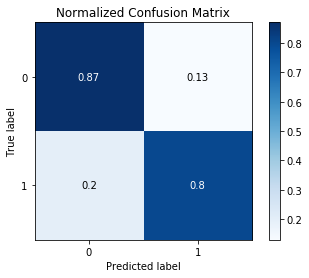

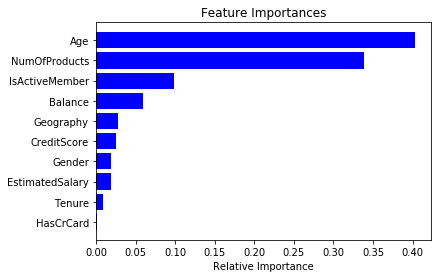

In [19]:
weights = {'n_estimators': 150, 'min_samples_split': 50, 'max_depth': 6}
model = RandomForestClassifier(**weights, oob_score = True) 
model.fit(train_features, train_labels)
pred_train_labels = model.predict(train_features)
pred_test_labels = model.predict(test_features)
pred_test_probas = model.predict_proba(test_features)
results = rf_results(model = model,
                     X_test = test_features,
                     y_pred_test = pred_test_labels, 
                     y_test = test_labels, 
                     y_pred_train = pred_train_labels, 
                     y_train = train_labels,
                     verbose = True,
                     plot = True
                    )
plot_importance(model)